# This is a Kaggle challenge

see https://www.kaggle.com/c/facial-keypoints-detection/overview



In [70]:
import os
import pandas as pd

# configuration for notebook
IN_COLAB = False
USE_GPU = IN_COLAB and False  # TPU and GPU only available in COLAB environment
USE_TPU = IN_COLAB and ((not USE_GPU) ^ False)  # XOR; either use GPU or TPU, cannot use both at the same time

BASE_PATH = '.'
LOG_DIR = os.path.join(BASE_PATH, 'logs')
MODEL_OUTPUT_DIR = os.path.join(BASE_PATH, 'face_keypoint_model')
KEEP_MODEL = True

# from google.colab import drive
if IN_COLAB:
    BASE_PATH = '/content/drive'
    drive.mount(BASE_PATH)

In [69]:
# load data
TRAIN_DATA_FILE = os.path.join(BASE_PATH, 'data', 'training.csv')
TEST_DATA_FILE = os.path.join(BASE_PATH, 'data', 'test.csv')

# read raw data from csv
train_data_raw = pd.read_csv(TRAIN_DATA_FILE)
test_data_raw = pd.read_csv(TEST_DATA_FILE)

In [58]:
# print column names
print(train_data_raw.columns)
print()
print(test_data_raw.columns)

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

Index(['ImageId', 'Image'], dtype='object')


In [5]:
import numpy as np

# NOT REQUIRED ANYMORE, BECAUSE 'NAN' VALUES GET HANDLED
# clean all rows which contain 'NA' cells
# this might be handled differently in future to have way more training data
# but for now lets go on with 'perfect' data rows
# train_data = train_data_raw.dropna()

# FOR DEBUG
# which columns contain how many 'missing' values
# print(train_data_raw.isna().sum())
# print basic statistic data for columns with most missing data
# print(train_data_raw[['left_eye_inner_corner_x', 'left_eye_inner_corner_y',
#             'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
#             'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
#             'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
#             'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
#             'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
#             'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
#             'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
#             'mouth_left_corner_x', 'mouth_left_corner_y',
#             'mouth_right_corner_x', 'mouth_right_corner_y',
#             'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
#             'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']].describe())

# use 'Image' column as input
train_input_raw = train_data_raw[train_data_raw.columns[-1]]

# use all remaining columns as features for training
train_features_raw = train_data_raw[train_data_raw.columns[:-1]]


# fill each 'nan' cell with random.normal value
# based on column mean and std
train_features = train_features_raw.copy()

for column in train_features.columns:
    filldata_column = np.random.normal(
        train_features[column].mean(),
        train_features[column].std(),
        train_features[column].isna().sum()
    )
    
    indexes = train_features.index[train_features[column].isna() == True]
    
    filldata_series = pd.Series(filldata_column, index=indexes)
    
    # simpler but with unpredictable result could be the line,
    # the simpler line is only possible without warning, when copying 
    # train_features_raw.copy() to train_features, no only setting "equal"
    train_features[column].fillna(filldata_series, inplace=True)
    # this line is fairly complicated due to Pandas warning, SettingWithCopy
    # see, https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    # train_features.iloc[:, train_features.columns.get_loc(column)] = \
    #   train_features.loc[:, (column)].fillna(filldata_series)

# convert DataFrame to Numpy array
train_features = np.array(train_features)

In [6]:
# convert image string to image data, and DataFrame to Numpy array
train_input = np.array([np.array(row.split(), dtype=np.uint8) for row in train_input_raw])

Image width: 96, height: 96
66.0335639098 39.0022736842
30.2270075188 36.4216781955
59.582075188000005 39.647422556399995
73.1303458647 39.9699969925
36.3565714286 37.3894015038
23.4528721805 37.3894015038
56.9532631579 29.0336481203
80.2271278195 32.2281383459
40.2276090226 29.0023218045
16.3563789474 29.6474706767
44.4205714286 57.0668030075
61.1953082707 79.9701654135
28.6144962406 77.38899248119999
43.3126015038 72.9354586466
43.1307067669 84.4857744361


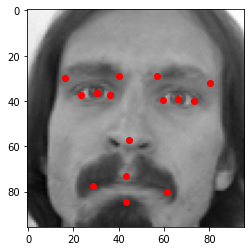

In [7]:
# show example image
import matplotlib.pyplot as plt

# extract image dimensions
img_width = img_height = np.sqrt(train_input.shape[1]).astype(np.uint8)

print('Image width: {}, height: {}'.format(img_width, img_height))

plt.imshow(train_input[0, :].reshape((img_width, img_height)), cmap='gray')

# show face keypoints on first input image
for x, y in zip(train_features[0,::2], train_features[0,1::2]):
    print(x, y)
    plt.scatter(x, y, color='r', linewidth=1)

In [66]:
if IN_COLAB:
    %tensorflow_version 2.x
# --------------------- THIS IS FOR GPU 
# --- activate in edit -> notebook-settings -> hardware acceleration
if USE_GPU:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))


# --------------------- THIS IS FOR TPU 
# --- activate in edit -> notebook-settings -> hardware acceleration
if USE_TPU:
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [65]:
# define cnn
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def get_model_lenet(input_width, input_height, input_channel_count, output_size):
    # similar but not identical to LeNet-5
    model = tf.keras.models.Sequential([
        keras.Input(shape=(input_width, input_height, input_channel_count)),
        layers.Conv2D(6, (5, 5), padding='same', activation='relu'),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(16, (5, 5), padding='valid', activation='relu'),
        layers.MaxPool2D((2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(output_size)
    ])

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(0.001),
        metrics=['accuracy'],
    )
    return model

def get_model(input_width, input_height, input_channel_count, output_size):
    model = tf.keras.models.Sequential([
        keras.Input(shape=(input_width, input_height, input_channel_count)),
        layers.Conv2D(32, (9, 9), padding='same', activation='relu'),
        layers.MaxPool2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='valid', activation='relu'),
        layers.Conv2D(128, (5, 5), padding='valid', activation='relu'),
        layers.Conv2D(192, (3, 3), padding='valid', activation='relu'),
        layers.MaxPool2D((2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_size),
    ])

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(0.001),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()],
    )
    return model


# configure cnn model
INPUT_CHANNEL_COUNT = 1  # due to gray-scale image we have only one color channel
OUTPUT_SIZE = len(train_features_raw.columns)

model = get_model(img_width, img_height, INPUT_CHANNEL_COUNT, OUTPUT_SIZE)

if USE_TPU:
    # creating the model in the TPUStrategy scope means we will train the model on the TPU
    with tpu_strategy.scope():
        model = get_model(img_width, img_height, INPUT_CHANNEL_COUNT, OUTPUT_SIZE)

# print model summary, e.g. layer information
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 32)        2624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 42, 128)       204928    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 192)       221376    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 192)      

# Network Architecture Search

1. dense layers (20-epochs)
  - 512 x 512 ok-ish, val-loss unstable very-high to same order of magnitude than loss
  - 1024 x 1024 worked good, val-loss seems stable
    - dropout on first and second dense; result worsens
    - dropout on first dense; better than dropouts on both dense layers but worse than without dropout
      - loss is worse but overfitting might be less (loss and val-loss nearly equal)
    - weight regularization (L2(0.0001)) on both dense layers; works ok, somehow high val-loss
    - weight regularization (L2(0.0001)) on first dense layer; 
  - 2048 x 1024 val-loss seems unstable very-high to low
  - 1024
    - loss ok but val-loss not really bad but not good either
    - weight regularization (L2(0.0001)) on dense layer before output;  loss ok but val-loss not really reduced
  - 512
    - nearly same performance as with 1024 neurons in dense layer before output, val-loss seems a little jumpy (low-high)
  - 256
    - equal performance compared to 512 neurons in dense layer before output
  - 128
    - performance comparable to 256 neurons, but val-loss a little bit higher
  - 64
    - this wirks pretty good, equally to 256 neurons before output
    - weight regularization (L2(0.0001)) does not help reduce val-loss
    - dropout, pretty worsens the loss value

2. batch normalization
  - worked ok-ish

3. network regularization

4. dropout?!
  - result worsens a little bit

In [71]:
# load pre-trained model or train new model
if os.path.exists(MODEL_OUTPUT_DIR) and KEEP_MODEL:
    model = keras.models.load_model(MODEL_OUTPUT_DIR)
else:
    tfb_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
    
    # data normalization
    # image values from [0,255] -> [0,1]
    train_input = train_input / 255.0
    
    # reshape data to match cnn input shape
    ds_train_input = train_input.reshape((-1, img_width, img_height, INPUT_CHANNEL_COUNT))

    # train
    model.fit(
        ds_train_input,
        train_features,
        epochs=40,
        validation_split=0.15,
        callbacks=[tfb_callback]
    )
    
    # save the model
    os.makedirs(MODEL_OUTPUT_DIR)
    model.save(MODEL_OUTPUT_DIR)

In [14]:
# load test data (done in first jupyter-notebook cell)
# show columns of test data
print(test_data_raw.columns)

# prepare test data for prediction
# convert image string to Numpy array
test_image_data = np.array([np.array(row.split(), dtype=np.uint8) for row in test_data_raw['Image']])
test_image_ids = np.array(test_data_raw['ImageId']).reshape(-1,1)

test_data = np.concatenate((test_image_ids, test_image_data), axis=1)

Index(['ImageId', 'Image'], dtype='object')


65.42383 39.065796
31.714846 38.340282
60.717857 38.228294
75.937935 40.62818
38.322857 36.28799
23.893711 34.752544
56.70715 24.22618
84.488205 28.143803
39.306694 25.57227
17.47607 23.473253
48.165184 51.029003
64.43372 76.5572
34.6051 70.6897
48.77117 69.41637
48.174393 87.889206


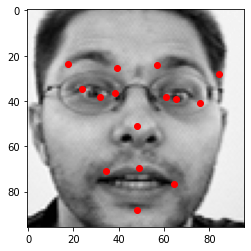

In [16]:
# predict for some images from test dataset
predictions = {}
for id, input in zip(test_data[0:5,0], test_data[0:5,1:]):
    normalized_input = (input / 255.0).reshape((-1, img_width, img_height, INPUT_CHANNEL_COUNT))
    predictions.update({id: model.predict(normalized_input)})


# show/plot face keypoint prediction
points = predictions[1]

plt.imshow(test_data[0, 1:].reshape((img_width, img_height)), cmap='gray')

# show face keypoints on first input image
for x, y in zip(points[0,::2], points[0,1::2]):
    print(x, y)
    plt.scatter(x, y, color='r', linewidth=1)

In [17]:
# prepare pre-trained face detector
import cv2

# load pre-trained opencv face detector
face_cascade_name = "/usr/share/opencv4/haarcascades/haarcascade_frontalface_alt.xml"
face_cascade = cv2.CascadeClassifier()

# Load the cascades
if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print('Error loading face cascade')

In [53]:
# define methods for face key point detection in streaming data, e.g. webcam

import skimage.transform as transform

def detect_faces(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # frame_gray = cv.equalizeHist(frame_gray)  # works slightly better without equalizeHist, read documentation for what it is good for, comes from a tutorial
    
    # detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    return faces

def mark_faces_in_frame(frame, faces):
    for (x, y, w, h) in faces:
        frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
    return frame

def detect_face_keypoints(frame, faces, model, model_input_size=(96, 96)):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    predictions = []
    for (x,y,w,h) in faces:
        # get face patch; region of interest
        face_roi = frame_gray[y:y+h, x:x+w]
        
        # resize ROI to model input size
        face = transform.resize(
            face_roi,
            model_input_size,
            order=0,
            preserve_range=True).astype(np.uint8)
        
        # normalize input, add channel dimension
        normalized_face = (face / 255.0).reshape(
            (-1, model_input_size[0], model_input_size[1], INPUT_CHANNEL_COUNT))
        
        # predict face key points
        predictions.append(model.predict(normalized_face))
    return predictions


def mark_face_key_points_in_frame(frame, faces, face_key_points, model_inp_width=96, model_inp_height=96):
    radius = 2
    color = (0, 0, 255)  # BGR; red
    border_thickness = -1  # -1 will fill the circle with given color
    
    for idx, points in enumerate(face_key_points):
        for (x, y) in zip(points[0, ::2], points[0, 1::2]):
            face_x = faces[idx][0]
            face_y = faces[idx][1]
            face_w = faces[idx][2]
            face_h = faces[idx][3]

            frame = cv2.circle(
                frame,
                (np.int(face_x + (x*(face_w/model_inp_width))), np.int(face_y + (y*(face_h/model_inp_height)))),
                radius, color, border_thickness)
                
    return frame

In [57]:
# try face key point prediction on webcam stream data
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

def handle_video_stream(vc):
    if vc.isOpened(): # try to get the first frame
        could_read_frame, frame = vc.read()
    else:
        could_read_frame = False

    while could_read_frame:
        # show frame
        cv2.imshow("preview", frame)

        # read frame
        could_read_frame, frame = vc.read()

        # detec faces in frame
        faces = detect_faces(frame)

        # plot box around faces
        frame = mark_faces_in_frame(frame, faces)

        # predict face keypoints on webcam live stream data
        face_key_points = detect_face_keypoints(frame, faces, model)

        # mark face key points in frame
        mark_face_key_points_in_frame(frame, faces, face_key_points)

        # read key for exit
        key = cv2.waitKey(50)
        if key == 27: # exit on ESC
            break

try:
    handle_video_stream(vc)
finally:
    vc.release()
    cv2.destroyWindow("preview")